<a href="https://colab.research.google.com/github/KatherineElkins/programming-humanity-2025/blob/main/schelling_model_111025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Schelling Segregation Model

## Background

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a random available grid space. While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

## Implementation

This is a complete implementation of the Schelling model using Mesa 3.x.

In [1]:
!pip install mesa matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 4.4 MB/s eta 0:00:00


In [2]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
class SchellingAgent(Agent):
    """
    Schelling segregation agent
    """
    def __init__(self, model, agent_type):
        super().__init__(model)
        self.type = agent_type
        self.happy = False

    def step(self):
        # Get neighbors
        neighbors = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False
        )

        # Count similar neighbors
        similar = 0
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar += 1

        # Check if happy
        if len(neighbors) > 0:
            self.happy = similar >= self.model.homophily * len(neighbors)
        else:
            self.happy = True

        # Move if unhappy
        if not self.happy:
            self.model.grid.move_to_empty(self)

In [4]:
class SchellingModel(Model):
    """
    Model class for the Schelling segregation model.
    """
    def __init__(self, height=20, width=20, density=0.8, minority_pc=0.5, homophily=0.4):
        super().__init__()
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily

        self.grid = MultiGrid(width, height, torus=True)

        # Set up agents
        for x in range(width):
            for y in range(height):
                if self.random.random() < self.density:
                    if self.random.random() < self.minority_pc:
                        agent_type = 1
                    else:
                        agent_type = 0

                    agent = SchellingAgent(self, agent_type)
                    self.grid.place_agent(agent, (x, y))

        self.datacollector = DataCollector(
            model_reporters={
                "happy": lambda m: sum([1 for a in m.agents if a.happy]),
                "segregated": self.get_segregated_agents
            }
        )

        self.running = True
        self.datacollector.collect(self)

    def get_segregated_agents(self):
        """
        Count segregated agents (those whose neighbors are all the same type)
        """
        segregated = 0
        for agent in self.agents:
            neighbors = self.grid.get_neighbors(
                agent.pos, moore=True, include_center=False
            )
            if len(neighbors) > 0:
                same_type = sum([1 for n in neighbors if n.type == agent.type])
                if same_type == len(neighbors):
                    segregated += 1
        return segregated

    def step(self):
        # Get all agents and shuffle for random activation
        agent_list = list(self.agents)
        self.random.shuffle(agent_list)

        # Have each agent step
        for agent in agent_list:
            agent.step()

        self.datacollector.collect(self)

        # Stop if all agents are happy
        if all([agent.happy for agent in self.agents]):
            self.running = False

In [5]:
# Run a single model
model = SchellingModel(height=20, width=20, density=0.8, minority_pc=0.5, homophily=0.4)

print(f"Starting with {len(list(model.agents))} agents")

for i in range(100):
    model.step()
    if not model.running:
        print(f"All agents happy after {i+1} steps")
        break

Starting with 326 agents
All agents happy after 9 steps


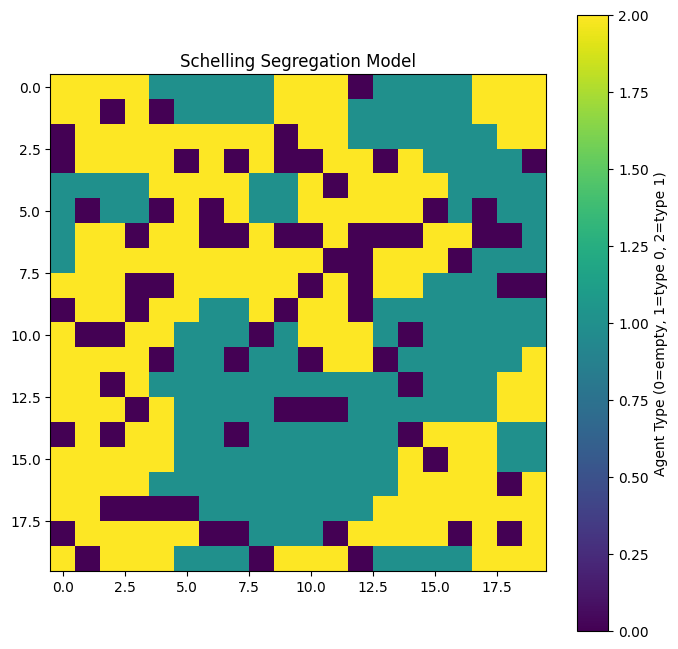

In [6]:
# Visualize the grid
def visualize_grid(model):
    grid_array = np.zeros((model.height, model.width))

    for agent in model.agents:
        x, y = agent.pos
        grid_array[y][x] = agent.type + 1  # 1 or 2

    plt.figure(figsize=(8, 8))
    plt.imshow(grid_array, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Agent Type (0=empty, 1=type 0, 2=type 1)')
    plt.title('Schelling Segregation Model')
    plt.show()

visualize_grid(model)

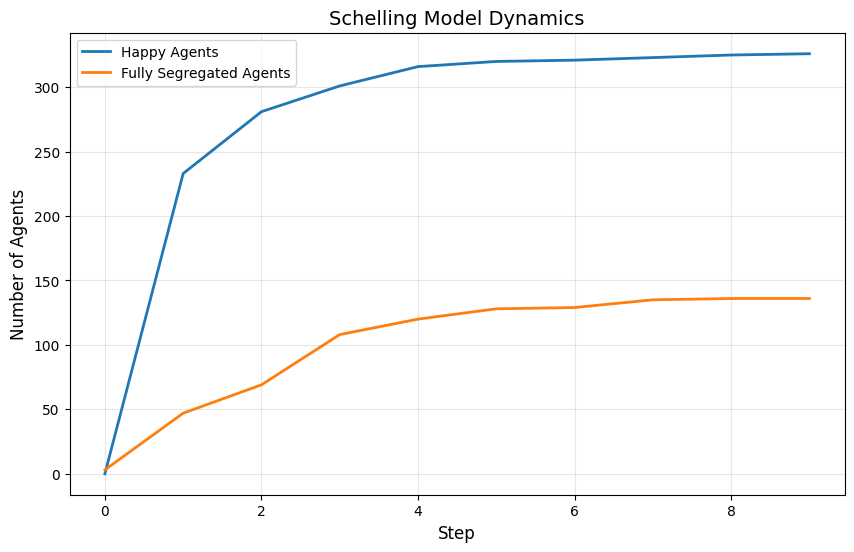

In [7]:
# Plot the time series
model_data = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(model_data['happy'], label='Happy Agents', linewidth=2)
plt.plot(model_data['segregated'], label='Fully Segregated Agents', linewidth=2)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Number of Agents', fontsize=12)
plt.title('Schelling Model Dynamics', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Run batch experiments with different homophily levels
homophily_levels = np.linspace(0.1, 0.8, 8)
results = []

for homophily in homophily_levels:
    print(f"Running with homophily={homophily:.2f}")
    model = SchellingModel(height=20, width=20, density=0.8,
                          minority_pc=0.5, homophily=homophily)

    for i in range(100):
        model.step()
        if not model.running:
            break

    # Get final segregation level
    final_data = model.datacollector.get_model_vars_dataframe().iloc[-1]
    results.append({
        'homophily': homophily,
        'happy': final_data['happy'],
        'segregated': final_data['segregated']
    })

df = pd.DataFrame(results)
print("\nResults:")
print(df)

Running with homophily=0.10
Running with homophily=0.20
Running with homophily=0.30
Running with homophily=0.40
Running with homophily=0.50
Running with homophily=0.60
Running with homophily=0.70
Running with homophily=0.80

Results:
   homophily  happy  segregated
0        0.1    314           9
1        0.2    315          14
2        0.3    327         125
3        0.4    328         147
4        0.5    316         223
5        0.6    308         252
6        0.7    322         304
7        0.8     89          28


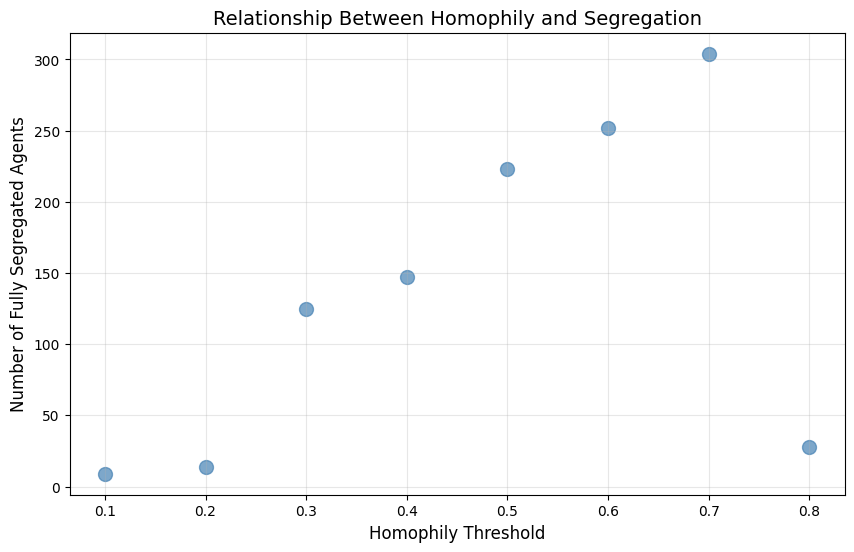

In [9]:
# Plot the relationship between homophily and segregation
plt.figure(figsize=(10, 6))
plt.scatter(df.homophily, df.segregated, s=100, alpha=0.7, color='steelblue')
plt.xlabel('Homophily Threshold', fontsize=12)
plt.ylabel('Number of Fully Segregated Agents', fontsize=12)
plt.title('Relationship Between Homophily and Segregation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()